## **Visual Information Processing and Management**
---
---

Università degli Studi Milano Bicocca \
CdLM Informatica — A.A 2025/2026

---
---

#### **Componenti del gruppo:**
— Oleksandra Golub (856706) \
— Andrea Spagnolo (879254)




### **Librerie**




In [1]:
import os, glob, time, copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from PIL import Image, ImageOps
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim

from torch.amp import GradScaler, autocast
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# su che device gira (CPU o CUDA se disponibile)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### **Dataset**




In [2]:
# definizione di una classe Args per raccogliere in un unico posto
# tutti i parametri di configurazione dell’esperimento
class Args:
    data_dir = '/kaggle/input/visual-exam-dataset-2/visual_dataset'  # percorso alla directory principale del dataset
    batch_size = 64 # dimensione del batch: numero di immagini elaborate insieme ad ogni forward/backward pass
    epochs = 50 # numero di epoche di addestramento (quante volte il modello vede l'intero dataset di training)
    lr = 3e-4 # learning rate per l’ottimizzatore 0.001
    num_workers = 4  # numero di processi worker usati dal DataLoader (valori > 0 velocizzano il caricamento dei dati, ma su Windows/macOS o in certi notebook può dare problemi)
    dry_run = False  # se True, il training viene eseguito solo su un batch

args = Args() # creazione di un'istanza della classe Args
args.lr = 1e-4         # override del learning rate per training from scratch

# verifica dell’esistenza del percorso del dataset prima di iniziare il caricamento dei dati
if os.path.exists(args.data_dir):
    print(f"Dataset root: {args.data_dir}") # se il percorso esiste, stampa il path del dataset
    print(f"Folders found: {os.listdir(args.data_dir)}") # stampa le cartelle presenti nella directory
else:
    print("Error: Path not found!") # se il percorso non esiste, segnala un errore

Dataset root: /kaggle/input/visual-exam-dataset-2/visual_dataset
Folders found: ['test_degradato', 'sports_labels.csv', 'valid', 'test', 'train']


### **Preprocessing**

In [3]:
class GrayWorldWB:
    def __call__(self, img):
        arr = np.asarray(img).astype(np.float32)
        mean = arr.mean(axis=(0,1), keepdims=True)
        arr = arr / (mean + 1e-6)
        arr = arr / arr.max()
        return Image.fromarray((arr * 255).astype(np.uint8))

class AutoContrast:
    def __call__(self, img):
        return ImageOps.autocontrast(img, cutoff=1)

preprocess = transforms.Compose([
    GrayWorldWB(),
    AutoContrast(),
])

### **Data Augmentation**




In [4]:
# dizionario che definisce le trasformazioni da applicare alle immagini
# separatamente per training e validation

data_transforms = {
    "train": transforms.Compose([
        # ridimensiona e ritaglia casualmente l’immagine a 224x224
        # la scala (0.4, 1.0) indica che il crop può coprire dal 40% al 100% dell’area originale
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)), 
        transforms.RandomHorizontalFlip(),  # flip orizzontale casuale 
        # transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.15),
        # transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.2),
        transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=2)], p=0.2),
        transforms.ToTensor(), # converte l’immagine PIL in un tensore PyTorch e normalizza i valori dei pixel in [0, 1]
        # normalizzazione con statistiche standard usate comunemente per CNN su immagini RGB
        # (manteniamo ImageNet mean/std come scelta di default; alternativa: calcolare mean/std del dataset)
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
       #  transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
    ]),
    "val": transforms.Compose([
        transforms.Resize(256), # ridimensiona il lato più corto dell’immagine a 256 pixel
        transforms.CenterCrop(224), # ritaglio centrale fisso a 224x224 (niente casualitàv visto che la validation deve essere deterministica)
        transforms.ToTensor(), # converte l’immagine PIL in un tensore PyTorch e normalizza i valori dei pixel in [0, 1]
        # stessa normalizzazione usata nel training per garantire coerenza tra train e validation
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# creazione dei dataset a partire da directory strutturate per classi
# ImageFolder assegna automaticamente le label in base ai nomi delle cartelle
image_datasets = {
    "train": datasets.ImageFolder(
        os.path.join(args.data_dir, "train"),
        data_transforms["train"]
    ),
    "val": datasets.ImageFolder(
        os.path.join(args.data_dir, "valid"),
        data_transforms["val"]
    ),
}

# abilita pin_memory solo se si sta utilizzando una GPU (cuda)
# pin_memory=True accelera il trasferimento dei batch dalla RAM alla GPU
# ma è inutile se si usa solo la CPU
pin_memory = (device.type == "cuda")

# abilita persistent_workers solo se vengono usati uno o più worker
# se True, i processi dei DataLoader restano attivi tra un’epoca e l’altra,
# riducendo l’overhead di creazione dei processi e migliorando le prestazioni
persistent = (args.num_workers > 0) 

# dizionario con i parametri comuni ai DataLoader
dl_kwargs = dict(
    batch_size=args.batch_size, # dimensione del batch
    num_workers=args.num_workers, # numero di processi per il caricamento dati
    pin_memory=pin_memory, # trasferimento da CPU a GPU più efficiente
    persistent_workers=persistent, # mantiene vivi i worker tra le epoche
)

# se i worker sono persistenti, abilita il prefetching dei batch
# ogni worker prepara in anticipo prefetch_factor batch, migliorando il throughput del DataLoader a costo di un maggiore uso di memoria
if persistent:
    dl_kwargs["prefetch_factor"] = 2

# creazione dei DataLoader per training e validation
dataloaders = {
    "train": DataLoader(image_datasets["train"], shuffle=True,  **dl_kwargs), # shuffle attivo solo per il training per migliorare la generalizzazione
    "val":   DataLoader(image_datasets["val"],   shuffle=False, **dl_kwargs), # niente shuffle in validation per garantire risultati deterministici
}

# calcolo del numero totale di campioni per ciascun split
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

# recupero dei nomi delle classi dal dataset di training (derivati automaticamente dalle cartelle)
class_names = image_datasets["train"].classes
# numero totale di classi del problema di classificazione
num_classes = len(class_names)

# stampa di un riepilogo del dataset
print(f"Number of classes: {num_classes}")
print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['val']}")

Number of classes: 100
Training samples: 19100
Validation samples: 500


### **Training del modello**




In [5]:
def train_model(
    model,               # modello PyTorch (nel nostro caso ResNet18) da addestrare
    dataloaders,         # dizionario con DataLoader per train e val
    dataset_sizes,       # dimensione dei dataset train/val
    criterion,           # funzione di loss 
    optimizer,           # ottimizzatore 
    scheduler,           # scheduler del learning rate (può essere None)
    device,              # device di esecuzione (cpu o cuda)
    args,                # oggetto con parametri 
    scaler=None,         # GradScaler per mixed precision (AMP), se usato su CUDA
    patience=3,          # epoche consecutive senza miglioramento prima di fermarsi (early stopping)
    min_delta=0.0,       # miglioramento minimo richiesto per considerare come migliorato
    monitor="val_loss",  # metrica da monitorare per early stopping e best model (val_loss o val_f1)
    save_path="best_model.pth",    # path dove salvare i pesi del miglior modello
):

    # tempo iniziale che ci servirà per calcolare la durata totale del training
    since = time.time()   

    # salvataggio iniziale dei pesi migliori... all'inizio sono quelli correnti del modello
    best_model_wts = copy.deepcopy(model.state_dict())  
    best_epoch = -1 

    # controllo di validità del parametro monitor
    if monitor not in ("val_loss", "val_f1"):
        raise ValueError("monitor must be 'val_loss' or 'val_f1'")

    # inizializza la migliore metrica best_metric a seconda della direzione:
    # - se monitoriamo val_loss: vogliamo minimizzarla
    # - se monitoriamo val_f1: vogliamo massimizzarla
    if monitor == "val_loss":
        best_metric = float("inf")    # valore iniziale molto grande per fare min
        mode = "min"
    else:
        best_metric = -float("inf")   # valore iniziale molto piccolo per fare max
        mode = "max"

    # contatore delle epoche senza miglioramento (per early stopping)
    epochs_no_improve = 0

    # struttura per salvare l'andamento delle metriche durante il training
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "train_f1":   [], "val_f1":   [],
    }

    # numero di epoche: si usa direttamente args.epochs
    num_epochs = args.epochs

    # loop sulle epoche
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # dizionario temporaneo per salvare le metriche di questa epoca
        epoch_stats = {}

        # due fasi per ogni epoca: training e validation
        for phase in ["train", "val"]:
            if phase == "train":
                model.train() # abilita dropout/bn in modalità training
            else:
                model.eval()  # disabilita dropout, bn in modalità eval

            # accumulatori per loss e accuratezza
            running_loss = 0.0
            running_corrects = 0
            seen = 0  # numero totale di campioni processati

            # liste per raccogliere predizioni e target e calcolare F1 macro a fine epoca
            all_preds = []
            all_targets = []

            # loop sui batch della fase corrente
            for inputs, labels in dataloaders[phase]:
                # sposta input e label sul device.
                # non_blocking=True può velocizzare se pin_memory=True e si usa CUDA
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # azzera i gradienti prima del backward
                # set_to_none=True è più efficiente e riduce overhead/memoria
                optimizer.zero_grad(set_to_none=True)

                # calcola gradienti solo in training
                with torch.set_grad_enabled(phase == "train"):
                    # autocast abilita mixed precision su GPU (cuda) per velocizzare e ridurre memoria
                    # su CPU è disabilitato (enabled=False)
                    with autocast(device_type="cuda", enabled=(device.type == "cuda")):
                        outputs = model(inputs)             # forward pass
                        loss = criterion(outputs, labels)   # calcolo loss

                    # predizione: classe con probabilità/logit massimo
                    _, preds = torch.max(outputs, 1) 

                    # backprop e aggiornamento pesi solo in training
                    if phase == "train":
                        # se stiamo usando AMP (scaler) su cuda: backward e step scalati
                        if scaler is not None and device.type == "cuda":
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            # caso standard (FP32): backward e step classici
                            loss.backward()
                            optimizer.step()

                # dimensione batch
                bs = inputs.size(0) 
                
                # accumula loss totale (moltiplicata per bs per fare media corretta a fine epoca)
                running_loss += loss.item() * bs

                # accumula numero di predizioni corrette
                running_corrects += torch.sum(preds == labels).item()

                # aggiorna contatore campioni visti
                seen += bs

                # salva predizioni e target su CPU per calcolare F1
                all_preds.append(preds.detach().cpu().numpy())
                all_targets.append(labels.detach().cpu().numpy())

            # aggiorna lo scheduler del learning rate una volta per epoca
            # (dopo aver finito la fase di training)
            if phase == "train" and scheduler is not None:
                scheduler.step()

            # calcolo metriche epoca (evita divisione per zero)
            denom = max(1, seen)
            epoch_loss = running_loss / denom
            epoch_acc = running_corrects / denom

            # concatena tutti i batch raccolti per calcolare F1 macro
            all_preds = np.concatenate(all_preds) if len(all_preds) else np.array([], dtype=np.int64)
            all_targets = np.concatenate(all_targets) if len(all_targets) else np.array([], dtype=np.int64)

            # F1 macro (multi-class, single-label)
            # zero_division=0 evita warning se una classe non viene mai predetta
            if all_targets.size > 0:
                epoch_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)
            else:
                epoch_f1 = 0.0

            # stampa metriche della fase
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1(macro): {epoch_f1:.4f}")

            # salva metriche della fase nel dizionario epoca
            epoch_stats[f"{phase}_loss"] = epoch_loss
            epoch_stats[f"{phase}_acc"] = epoch_acc
            epoch_stats[f"{phase}_f1"] = epoch_f1

        # salva la history dopo train+val
        history["train_loss"].append(epoch_stats["train_loss"])
        history["val_loss"].append(epoch_stats["val_loss"])
        history["train_acc"].append(epoch_stats["train_acc"])
        history["val_acc"].append(epoch_stats["val_acc"])
        history["train_f1"].append(epoch_stats["train_f1"])
        history["val_f1"].append(epoch_stats["val_f1"])

        # early stopping: controlla se la metrica monitorata è migliorata in validation
        current = epoch_stats[monitor]

        # determina se c'è stato miglioramento rispetto a best_metric
        improved = False
        if mode == "min":
            improved = (best_metric - current) > min_delta # miglioramento = diminuzione sufficientemente grande
        else:
            improved = (current - best_metric) > min_delta # miglioramento = aumento sufficientemente grande

        if improved: 
            # se migliorato, allora aggiorna best
            best_metric = current
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())

            # salva su disco i pesi del miglior modello trovato finora
            torch.save(model.state_dict(), save_path)

            # reset contatore epoche senza miglioramento
            epochs_no_improve = 0
        else:
            # nessun miglioramento: incrementa contatore
            epochs_no_improve += 1

        # se non migliora per patience di epoche, interrompe il training
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (best {monitor} at epoch {best_epoch}: {best_metric:.6f})")
            break

    # calcola il tempo totale
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed/60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best {monitor}: {best_metric:.6f} at epoch {best_epoch}")

    # ripristina i pesi migliori prima di restituire il modello
    model.load_state_dict(best_model_wts)
    return model, history

In [6]:
def build_resnet18(
    num_classes: int,                     # numero di classi del problema di classificazione
    weights_path: str | None = None,      # path ai pesi pretrained (offline); None = inizializzazione casuale
    freeze_backbone: bool = False,         # se True congela il backbone e allena solo la fully connected
    device: torch.device | None = None    # device su cui spostare il modello (cpu o cuda)
):
    """
    Crea una ResNet18, opzionalmente carica pesi pretrained OFFLINE,
    sostituisce la fully-connected per il numero di classi desiderato
    e opzionalmente congela (freeze) il backbone.
    """

    # se il device non viene passato esplicitamente, si usa CUDA se disponibile, altrimenti CPU
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # si crea l'architettura ResNet18 senza scaricare pesi da internet
    # (weights=None evita download automatici, utile in ambienti offline come Kaggle)
    model = models.resnet18(weights=None)

    # carica opzionalmente i pesi pretrained da file locale (offline)
    # map_location="cpu" garantisce che il caricamento funzioni anche se il file è stato salvato su un'altra macchina/GPU
    if weights_path is not None:
        state_dict = torch.load(weights_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # sostituisce l'ultimo layer fully-connected
    # ResNet18 termina con una FC per 1000 classi (ImageNet); qui viene adattata al numero di classi del dataset corrente
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    # Freeze del backbone:
    # - tutti i layer convoluzionali vengono congelati
    # - solo la fully-connected rimane allenabile
    if freeze_backbone:
        for p in model.parameters():
            p.requires_grad = False
        for p in model.fc.parameters():
            p.requires_grad = True

    # Sposta il modello sul device scelto e lo restituisce
    return model.to(device)


def build_amp_scaler(device: torch.device) -> GradScaler:
    """
    Crea GradScaler per AMP:
    - su CUDA è abilitato
    - su CPU è automaticamente disabilitato (non cambia nulla)
    """

    # GradScaler gestisce la scalatura dinamica della loss in FP16
    # enabled=True solo se si usa una GPU CUDA
    return GradScaler(enabled=(device.type == "cuda"))


In [7]:
# percorso ai pesi pretrained di ResNet18 salvati localmente (offline)
#WEIGHTS_PATH = "/kaggle/input/resnet18-f37072fd-pth/pytorch/default/1/resnet18-f37072fd.pth"
#print("Using weights:", WEIGHTS_PATH)

# creazione del modello tramite la funzione di utilità:
# - carica ResNet18
# - importa i pesi pretrained offline
# - sostituisce la fully connected per il numero corretto di classi
# - congela il backbone (allena solo la FC)
# - sposta il modello sul device scelto (CPU o GPU)
#model = build_resnet18(
 #   num_classes=num_classes,
 #   weights_path=WEIGHTS_PATH,
  #  freeze_backbone=True,
 #  device=device
#)

model = build_resnet18(
    num_classes=num_classes,
    weights_path=None,        # niente pesi pretrain
    freeze_backbone=False,    # allena tutta la rete
    device=device
)

# definizione della funzione di loss per classificazione multi-classe
# CrossEntropyLoss combina LogSoftmax e NLLLoss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# definizione dell'ottimizzatore:
# vengono passati solo i parametri con requires_grad=True (in questo caso, solo la fully connected se il backbone è congelato)
optimizer_ft = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=args.lr, 
    weight_decay=5e-4
)

# scheduler del learning rate:
# ogni step_size epoche il learning rate viene moltiplicato per gamma
#exp_lr_scheduler = lr_scheduler.StepLR(
  #  optimizer_ft,
   # step_size=7,
   # gamma=0.1
#)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_ft,
    T_max=args.epochs
)

# creazione dello scaler per Automatic Mixed Precision (AMP):
# - su GPU (CUDA) abilita il training in mixed precision
# - su CPU è disabilitato e non modifica il comportamento
scaler = build_amp_scaler(device)


# avvio del training:
# - utilizza DataLoader di training e validation
# - applica early stopping e scheduler
# - usa AMP in modo trasparente tramite 'scaler'
# - restituisce il modello con i pesi migliori e lo storico delle metriche
model, history = train_model(
    model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer_ft,
    # exp_lr_scheduler,
    scheduler,
    device,
    args,
    scaler=scaler
)

Epoch 0/49
----------
train Loss: 4.0281 Acc: 0.0985 F1(macro): 0.0867
val Loss: 3.4368 Acc: 0.2400 F1(macro): 0.1888
Epoch 1/49
----------
train Loss: 3.4553 Acc: 0.2119 F1(macro): 0.1915
val Loss: 3.1563 Acc: 0.2920 F1(macro): 0.2485
Epoch 2/49
----------
train Loss: 3.1167 Acc: 0.3009 F1(macro): 0.2806
val Loss: 2.8624 Acc: 0.3980 F1(macro): 0.3576
Epoch 3/49
----------
train Loss: 2.8686 Acc: 0.3705 F1(macro): 0.3530
val Loss: 2.5627 Acc: 0.4520 F1(macro): 0.4082
Epoch 4/49
----------
train Loss: 2.6432 Acc: 0.4370 F1(macro): 0.4232
val Loss: 2.3910 Acc: 0.5180 F1(macro): 0.4863
Epoch 5/49
----------
train Loss: 2.4586 Acc: 0.4964 F1(macro): 0.4860
val Loss: 2.1401 Acc: 0.5960 F1(macro): 0.5820
Epoch 6/49
----------
train Loss: 2.2923 Acc: 0.5484 F1(macro): 0.5409
val Loss: 2.0901 Acc: 0.6120 F1(macro): 0.5869
Epoch 7/49
----------
train Loss: 2.1670 Acc: 0.5853 F1(macro): 0.5796
val Loss: 1.9447 Acc: 0.6620 F1(macro): 0.6457
Epoch 8/49
----------
train Loss: 2.0476 Acc: 0.6249 F1(

In [8]:
print(model.fc)
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Linear(in_features=512, out_features=100, bias=True)
Trainable params: 11227812


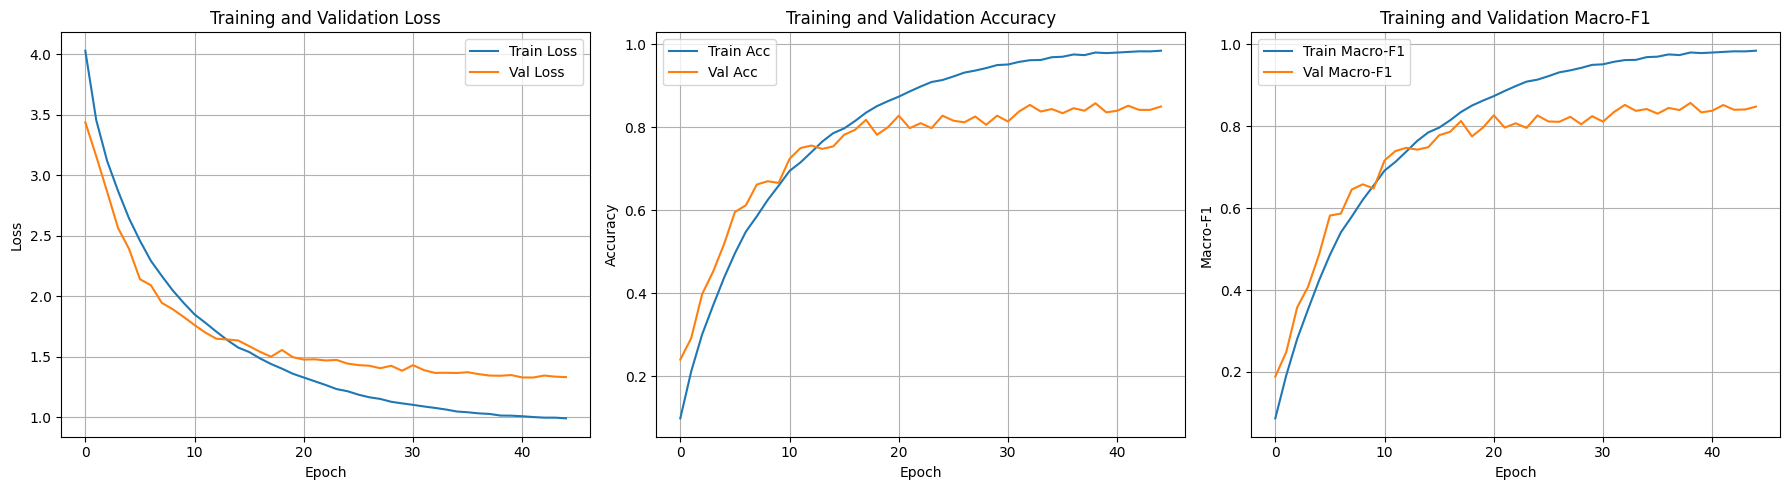

In [9]:
epochs_range = range(len(history["train_loss"]))
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history["train_loss"], label='Train Loss')
plt.plot(epochs_range, history["val_loss"], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history["train_acc"], label='Train Acc')
plt.plot(epochs_range, history["val_acc"], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

# Macro-F1 (replaces mAP)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history["train_f1"], label='Train Macro-F1')
plt.plot(epochs_range, history["val_f1"], label='Val Macro-F1')
plt.title('Training and Validation Macro-F1')
plt.xlabel('Epoch'); plt.ylabel('Macro-F1')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
def evaluate_test_set(model, test_dir, batch_size=64, device='cuda'):
    """
    Valuta il modello sul test set e stampa Accuracy e Macro-F1.
    Il test set NON viene usato per il training né per la selezione del modello.
    """
    
    # controllo dell'esistenza del percorso del test set
    if not os.path.exists(test_dir):
        print(f"Error: Test directory not found at {test_dir}")
        return

    # definizione delle trasformazioni per il test set
    # - Resize + CenterCrop rendono le immagini coerenti con l'input della rete (224x224)
    # - nessuna data augmentation: il test deve essere deterministico
    # - normalizzazione con le statistiche ImageNet, come in training e validation
    test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # caricamento del dataset di test
    # ImageFolder assegna automaticamente le label in base ai nomi delle cartelle
    # struttura attesa: test_dir/classe_x/immagine.png
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

    # abilita pin_memory solo se si utilizza una GPU CUDA
    # serve a velocizzare il trasferimento dei dati dalla RAM alla GPU
    pin_memory = (device.type == "cuda")
    
    # creazione del DataLoader per il test set
    # - shuffle=False: l'ordine dei campioni non deve essere casuale
    # - num_workers=4 è adatto su Linux/Kaggle (su Windows/Mac può essere impostato a 0)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=pin_memory
    )

    # stampa informazioni di riepilogo sul test set
    print(f"Test samples found: {len(test_dataset)}")
    print(f"Classes found: {len(test_dataset.classes)}")

    # fase di inference
    # - model.eval(): disattiva dropout e batch normalization in modalità training
    # - model.to(device): assicura che il modello sia sul device corretto
    model.eval()
    model.to(device)

    # liste per raccogliere tutte le predizioni e le etichette reali
    all_preds = []
    all_targets = []

    print("Running evaluation on Test set...")

    # disabilita il calcolo dei gradienti: riduce uso di memoria e velocizza l'inference
    with torch.no_grad():
        for inputs, labels in test_loader:
            # sposta batch e label sul device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(inputs) 
            # predizione della classe con logit massimo
            _, preds = torch.max(outputs, 1)

            # salva predizioni e target su CPU per il calcolo delle metriche
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # calcolo delle metriche finali sul test set
    # accuracy: percentuale totale di predizioni corrette
    test_acc = accuracy_score(all_targets, all_preds)
    # macro-F1: media della F1 su tutte le classi (robusta in caso di classi sbilanciate)
    test_f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    # stampa dei risultati finali
    print("-" * 30)
    print(f"Test Set Accuracy:   {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"Test Set Macro F1:   {test_f1:.4f}")
    print("-" * 30)

    return test_acc, test_f1


# percorso al test set
test_dir_path = '/kaggle/input/visual-exam-dataset/visual_dataset/test'

# esecuzione della valutazione:
# 'model' è il modello addestrato, già caricato con i pesi migliori
evaluate_test_set(
    model,
    test_dir_path,
    batch_size=args.batch_size,
    device=device
)

Test samples found: 500
Classes found: 100
Running evaluation on Test set...
------------------------------
Test Set Accuracy:   0.8640 (86.40%)
Test Set Macro F1:   0.8603
------------------------------


(0.864, 0.8603026973026973)